In [1]:
import sys
import random
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage.transform import resize
from skimage.morphology import label

# from keras.models import Model, load_model
# from keras.layers import Input
# from keras.layers.core import Dropout, Lambda
# from keras.layers.convolutional import Conv2D, Conv2DTranspose
# from keras.layers.pooling import MaxPooling2D
# from keras.layers.merge import concatenate
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras import backend as K

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

import tensorflow as tf
import time

In [2]:
# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
#TRAIN_PATH = './dataset/training/'
#TEST_PATH = './dataset/testing/'
TRAIN_NUM = 1700
TEST_NUM = 300
sample_dir = "./training/sample/"
mask_dir = "./training/mask/"
test_sample_dir = "./testing/sample/"
test_mask_dir = "./testing/mask/"


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

#### sample_ids
* contain all the names of sample and mask data IN TRAINING SET
* mask_ids = sample_ids + "_matte.png"

#### test_sample_ids
* contain all the names of sample and mask data IN TESTING SET
* test_mask_ids = test_sample_ids + "_matte.png"


In [3]:
#Get the filenames of training and testing data
sample_ids = next(os.walk(sample_dir))[2]
test_sample_ids = next(os.walk(test_sample_dir))[2]
print(sample_ids[:10])
print(test_sample_ids[:10])

['01167.png', '01386.png', '01152.png', '01527.png', '01359.png', '01255.png', '00620.png', '01586.png', '00336.png', '01416.png']
['00282.png', '00078.png', '00281.png', '00234.png', '00289.png', '00179.png', '00125.png', '00286.png', '00204.png', '00261.png']


In [4]:
#First create several np arrays with the correct shapes
X_train = np.zeros((len(sample_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(sample_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

### Getting the training data ready loaded into X_train and Y_train

In [5]:
#First create several np arrays with the correct shapes
X_test = np.zeros((len(test_sample_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_sample_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [6]:
# THRES = 70
# sys.stdout.flush()
# for n, id_ in tqdm(enumerate(sample_ids), total=TRAIN_NUM):
#     sample_path = sample_dir + id_
#     # also read in the corresponding mask
#     mask_path = mask_dir + id_[:-4] + "_matte.png"
    
#     img = imread(sample_path)
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_train[n] = img
    
#     mask_ = imread(mask_path)
#     mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                             preserve_range=True), axis=-1)
    
#     for i in range(mask_.shape[0]):
#         for j in range(mask_.shape[1]):
#             for k in range(mask_.shape[2]):
#                 if mask_[i,j,k] > THRES:
#                     mask_[i,j,k] = 255
#                 else:
#                     mask_[i,j,k] = 0
                    
#     Y_train[n] = mask_

In [7]:
# THRES = 70
# for n, id_ in tqdm(enumerate(test_sample_ids), total=TEST_NUM):
#     test_sample_path = test_sample_dir + id_
#     # also read in the corresponding mask
#     test_mask_path = test_mask_dir + id_[:-4] + "_matte.png"
    
#     img = imread(test_sample_path)
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_test[n] = img
    
#     mask_ = imread(test_mask_path)
#     mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                             preserve_range=True), axis=-1)
    
#     for i in range(mask_.shape[0]):
#         for j in range(mask_.shape[1]):
#             for k in range(mask_.shape[2]):
#                 if mask_[i,j,k] > THRES:
#                     mask_[i,j,k] = 255
#                 else:
#                     mask_[i,j,k] = 0
                    
#     Y_test[n] = mask_

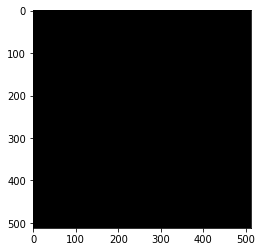

In [8]:
#NOW examine if our data preprocessing is done correctly
# someImg = random.choice(Y_train)
someImg = X_test[200]
plt.imshow(someImg)
plt.show()

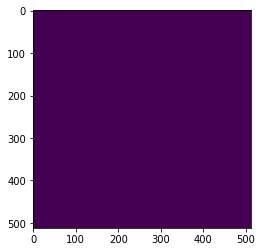

[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]


In [9]:
anotherImg = Y_test[200]
# print(Y_train.shape)
# plt.imshow(anotherImg[:,:,0], cmap = "Greys")
plt.imshow(anotherImg[:,:,0])
plt.show()

print(anotherImg[200:300,200:300,0])

### Building the model here

In [10]:
def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

In [11]:
img_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

model = models.Model(inputs=[inputs], outputs=[outputs])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [12]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [13]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [14]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [15]:
ls -al

total 1893532
drwxr-xr-x 9 jet jet       4096 Jul 23 18:20 ./
drwxr-xr-x 3 jet jet       4096 Sep 16  2018 ../
-rw-r--r-- 1 jet jet      56987 Jul 23 09:54 data_augmentation_and_playing_with_cifar10.ipynb
-rw-r--r-- 1 jet jet 1191198083 Jul 23 09:38 dataset_kaggle.zip
-rw-rw-r-- 1 jet jet          0 Sep 16  2018 .gitkeep
drwxr-xr-x 2 jet jet       4096 Jul 23 08:57 .ipynb_checkpoints/
-rw-r--r-- 1 jet jet  373798624 Jul 23 12:56 maybe_overfitting.hdf5
drwxr-xr-x 2 jet jet       4096 Jul 23 09:23 models/
-rw-r--r-- 1 jet jet      38603 Jul 23 18:20 Pioneer_Main.ipynb
-rw-r--r-- 1 jet jet       2219 Jul 23 08:53 README.ipynb
-rw-r--r-- 1 jet jet      21585 Jul 23 08:57 Skimage+Learning.ipynb
-rw-r--r-- 1 jet jet       6358 Jul 23 18:14 skimage_numpy.ipynb
drwxr-xr-x 4 jet jet       4096 Jul 13 23:04 testing/
drwxr-xr-x 2 jet jet       4096 Sep 16  2018 tests/
drwxr-xr-x 2 jet jet       4096 Jul 23 12:57 train/
drwxr-xr-x 4 jet jet       4096 Jul 13 22:38 training/
drwxr-xr-x 2 jet jet   

In [16]:
save_model_path = './weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', save_best_only=True, verbose=1)

### Use a custom data generator

In [17]:

from tensorflow.keras.preprocessing.image import *

# Create an ImageDataGenerator object and perform data augmentation
train_datagen = ImageDataGenerator(
#     featurewise_center=True,
    rescale = 1./255, # This step is crucial
    rotation_range = 0.,
    shear_range = 0.,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    horizontal_flip= False
    )

# train_datagen = ImageDataGenerator(
#     rescale = 1./255, # This step is crucial
#     )

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [34]:
def train_and_test_image_generator(bs, mode, aug=None):
    # Use the sample_ids and test_sample_ids for img reading in this case
    
    # This counter is used for marking the position in sample_ids and test_sample_ids
    # to ensure that new batches generated are not repetitions
    counter = 0
    
    # loop indefinitely
    while True:
        # initialize our batches of images and labels
        images = []
        masks = []
        
        # keep looping until we reach our batch size
        while len(images) < bs:
            # read the images in
            
            #First determine the path to read the file
            if mode == "train":
                img_path = sample_dir + sample_ids[counter]
            elif mode == "test":
                img_path = test_sample_dir + test_sample_ids[counter]
            else:
                pass
            
            if mode == "train":
                mask_path = mask_dir + sample_ids[counter][:-4] + "_matte.png"
            elif mode == "test":
                mask_path = test_mask_dir + test_sample_ids[counter][:-4] + "_matte.png"
            else:
                pass
            
            # Update the counter
            # If at the end of the training image data
            counter += 1
            if mode == "train" and counter >= TRAIN_NUM:
                counter = 0
            elif mode == "test" and counter >= TEST_NUM:
                counter = 0
            
            #Reading, resizing and expanding the images
            img = imread(img_path) # (800x600x3)
            mask = imread(mask_path) #(800x600)
            
            img = resize(img, (512, 512))
            mask = resize(mask, (512, 512))
            
            # Some kind of preprocessing of the mask
            # Thresholding + Expand to (512x512x1)
            mask = (mask > 128) * 255
            mask = np.expand_dims(mask, axis=2)
 
            img = img.astype(np.float32)
            mask = mask.astype(np.float32)
#             print(img[:5,:5,:])
#             print(mask[:5,:5,:])
#             img = img / 255.
#             mask = mask / 255.
            
            # update our corresponding batches lists
            images.append(img)
            masks.append(mask)
            
            
        # if the data augmentation object is not None, apply it
#         if aug is not None:
#             (return_images, someY) = next(aug.flow(np.array(images),np.zeros([len(images)]), seed = int(counter % 50), batch_size=bs))
#             (return_masks, someY) = next(aug.flow(np.array(masks),np.zeros([len(masks)]), seed = int(counter % 50), batch_size=bs))
#         else:
        return_images = images
        return_masks = masks
        

        
#         print(return_images.dtype)
#         print(return_masks.dtype)
#         float32
        
        # yield the batch to the calling function
        yield (return_images, return_masks)

In [35]:
# train_datagen.fit(X_train, seed = 4)

In [36]:
# Here the two generators are instantiated to fit in the model.fit_generator()
batchSize = 8
train_generator = train_and_test_image_generator(batchSize, mode="train", aug=None)
test_generator = train_and_test_image_generator(batchSize, mode="test", aug=None)

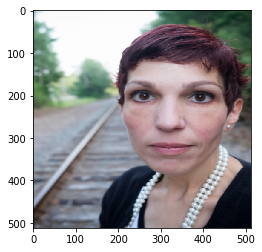

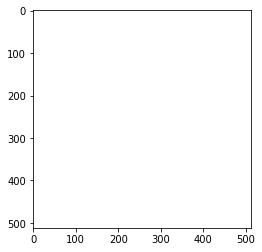

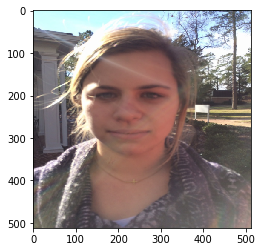

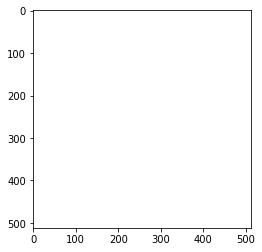

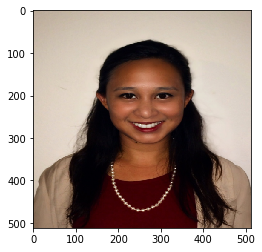

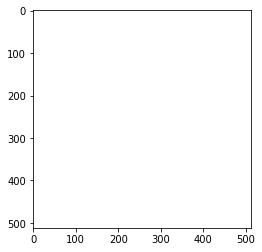

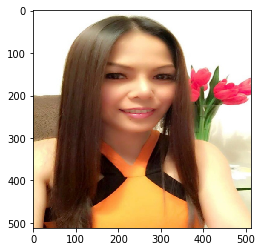

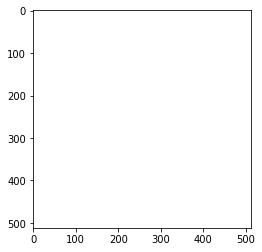

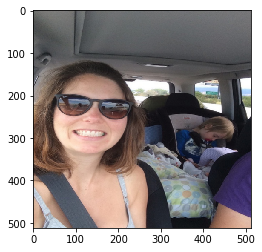

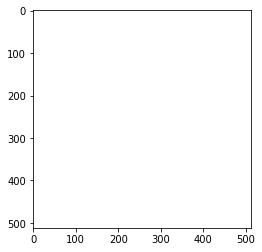

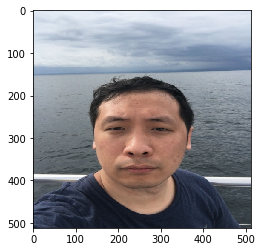

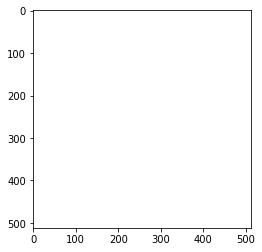

In [37]:

for i in range(6):
    imgs = None
    gts = None
    (imgs, gts) = next(train_generator)
    
#     print(imgs.shape)

    img = imgs[0]
#     plt.imshow(img)
    img = np.trunc(img*255)
    img = img.astype(int)
#     print(img.shape)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
#     print(np.floor(imgs[i][:10,:10,:]*255))
    
    plt.show()
#     print(gt.shape)

    gt = gts[0][:,:,0]*255
    
    gt = (gt > 0.5) * 255
#     ret,thresh = cv2.threshold(gt,200,255,cv2.THRESH_BINARY_INV)
#     for i in range(gt.shape[0]):
#         for j in range(gt.shape[1]):
#             if gt[i,j] > 0.1
    plt.imshow(gt, cmap = "Greys")
    plt.show()

In [ ]:
# Alternatively, load the weights directly: model.load_weights(save_model_path)
# model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss,
#                                                            'dice_loss': dice_loss})

In [ ]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

In [ ]:
# from tensorflow.keras.utils import multi_gpu_model
# parallel_model = multi_gpu_model(model, gpus=2)

In [ ]:
# parallel_model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

In [ ]:
# gpu_options = tf.GPUOptions(allow_growth=True)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [ ]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=len(X_train)//batchSize,
                    epochs=5,
                    validation_data = test_generator,
                    validation_steps = len(X_test[:100])//10,
                    callbacks=[cp]
                    )


In [ ]:
model.save("./maybe_overfitting.hdf5")

In [ ]:
!ls -al

In [ ]:
model.evaluate_generator(test_generator,
steps=30, verbose =1)

In [ ]:
# Plot training & validation accuracy values

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_dice_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png')

In [ ]:
# #There must be an alternative to doing this
predictions = model.predict(X_test[:20]/255.) # NOTE THAT the input values should be normalized to be between 0 and 1

In [ ]:
print(Y_test.shape)
print(predictions.shape[0])

for i in range(predictions.shape[0]):
    img = predictions[i][:,:,0]
    img = np.trunc(img*255)
    img = img.astype(int)
    plt.imshow(img, cmap= 'Greys')
    plt.show()
    plt.imshow(Y_test[i][:,:,0], cmap = 'Greys')
    plt.show()
    
    
# for i in range(IMG_WIDTH):
#     for j in range(IMG_HEIGHT):
#         print(img[i,j], end = ' ')
        
# for i in range(predictions.shape[0]):
#     plt.imshow(Y_test[i], cmap= 'Greys')
#     plt.show()
#     plt.imshow(255*predictions[i].reshape([IMG_WIDTH,IMG_HEIGHT]))
#     time.sleep(0.4)

#### Below is a test to see how the two generators are performing image augmentation

In [ ]:
!ls -a
!rm -rf ./train
!rm -rf ./train_masks
!mkdir ./train
!mkdir ./train_masks

In [ ]:

# def image_generator_data_augmentation(bs, number_of_train, number_of_test, mode, aug=None):
#     # Use the sample_ids and test_sample_ids for img reading in this case
    
#     # This counter is used for marking the position in sample_ids and test_sample_ids
#     # to ensure that new batches generated are not repetitions
#     counter = 0
    
#     # loop indefinitely
#     while True:
#         # initialize our batches of images and labels
#         images = []
#         masks = []
        
#         # keep looping until we reach our batch size
#         while len(images) < bs:
#             # read the images in
            
#             #First determine the path to read the file
#             if mode == "train":
#                 img_path = sample_dir + sample_ids[counter]
#             elif mode == "test":
#                 img_path = test_sample_dir + test_sample_ids[counter]
#             else:
#                 pass
            
#             if mode == "train":
#                 mask_path = mask_dir + sample_ids[counter][:-4] + "_matte.png"
#             elif mode == "test":
#                 mask_path = test_mask_dir + test_sample_ids[counter][:-4] + "_matte.png"
#             else:
#                 pass
            
#             # Update the counter
#             # If at the end of the training image data
#             counter += 1
#             if mode == "train" and counter >= number_of_train:
#                 counter = 0
#             elif mode == "test" and counter >= number_of_test:
#                 counter = 0
            
#             #Resizing and expanding the images
#             img = cv2.imread(img_path)
#             mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
#             img = cv2.resize(img, None, fx = 0.8533, fy = 0.64, interpolation = cv2.INTER_LINEAR)
# #             print(img_path)
# #             print(mask_path)

#             mask = cv2.resize(mask, None, fx = 0.8533, fy = 0.64, interpolation = cv2.INTER_LINEAR)
#                 # Some kind of preprocessing of the mask
#             ret,mask = cv2.threshold(mask,200,255,cv2.THRESH_BINARY_INV)
#             mask = np.expand_dims(mask, axis=2)
 
#             # update our corresponding batches lists
#             images.append(img)
#             masks.append(mask)
# #             print(mask.shape)
# #         print(mask.shape)
#         # if the data augmentation object is not None, apply it
#         if aug is not None:
#             (return_images, someY) = next(aug.flow(np.array(images),np.zeros([len(images)]), seed = 4, batch_size=bs, save_to_dir="./train/", save_prefix='img', save_format='png'))
#             (return_masks, someY) = next(aug.flow(np.array(masks),np.zeros([len(masks)]), seed = 4, batch_size=bs, save_to_dir="./train_masks/", save_prefix='img', save_format='png'))
#         # yield the batch to the calling function 
#         yield (return_images, return_masks)

In [ ]:
test_generator = train_and_test_image_generator(batchSize, 30, 10, mode="test", aug=test_datagen )
train_generator = trian_and_test_image_generator(batchSize, 30, 10, mode="train", aug=train_datagen)

In [ ]:
# ! ls -a ./train

In [ ]:
# os.listdir("./train")

In [ ]:
# import cv2
# img = cv2.imread('img_3_7408.png')
# print(type(img))
# for img_id in os.listdir("./train"):
#     img = cv2.imread(img_id)
#     print(img_id)
#     print(type(img))
#     plt.imshow(img)
#     plt.show()